In [1]:
# Classification of ASD vs Controls based on different atlases.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn.functional as F

import os.path as osp

In [2]:
class AbideData(DataLoader):
    
    def __init__(self, 
                 atlas_name='schaefer_100',
                 root_dir='/data_local/deeplearning/ABIDE_ML_inputs/', 
                 data_info_file='data_info.csv', 
                 nTime_min=150, # Take all subjects that have at least 150 time points
                 zscore=False,
                 split_ratios = [0.8, 0.1], # Default is 80% for training, 10% validation
                 split='train'): 
        super(AbideData).__init__()
        
        
        # Check if valid atlas name
        if atlas_name not in ['AAL', 'HO_cort_maxprob_thr25-2mm', 'schaefer_100', 'schaefer_400']:
            raise ValueError('atlas_name not found')
        
        
        # Read the parent CSV file
        data_info = pd.read_csv(osp.join(root_dir, data_info_file))
        
        # Filter the dataframe to contain subjects with nTimes > 150
        data_info = data_info[data_info.nTimes > nTime_min]
        
        
        # Split the data according to train/val/test
        train_split = int(split_ratios[0] * len(data_info))
        val_split = int((split_ratios[0] + split_ratios[1]) * len(data_info))
        
        if split == 'train':
            print(f'loading training data ...')
            START_INDEX = 0
            END_INDEX = train_split
            
        if split == 'val':
            START_INDEX = train_split
            END_INDEX = val_split
            
        if split == 'test':
            print(f'loading testing data ...')
            START_INDEX = val_split
            END_INDEX = -1
        
        # Filter the data to include only subjects in the split
        data_info = data_info.iloc[START_INDEX:END_INDEX]
        
        # Determine the nchannels (=nrois) from the data by using the first sample
        sample_file = data_info['tc_file'].iloc[0].replace('ATLAS', atlas_name)
        nrois = pd.read_csv(sample_file).values.shape[1]
        
        N_corr_mat = int(nrois*(nrois-1)/2)
        # Initialize an np array to store all timecourses and labels
        self.total_subjects = len(data_info)
        self.tc_data = np.zeros((self.total_subjects, nrois, nTime_min))
        self.corr_data = np.zeros((self.total_subjects, N_corr_mat))
        labels = np.zeros(self.total_subjects, dtype=int)

        
        # Load data
        
        for i, sub_i in enumerate(data_info.index):
            
            tc_file = data_info['tc_file'].loc[sub_i].replace('ATLAS', atlas_name)
            tc_vals = pd.read_csv(tc_file).values.transpose()[:, :nTime_min]

            corr_file = data_info['corr_file'].loc[sub_i].replace('ATLAS', atlas_name)
            corr_vals = np.load(corr_file)
            
            if zscore:
                tc_vals = (tc_vals - np.mean(tc_vals, axis=1).reshape(-1,1))/np.std(tc_vals, axis=1).reshape(-1,1)
            
            self.tc_data[i] = tc_vals
            self.corr_data[i] = corr_vals
            
            labels[i] = data_info['DX_GROUP'].loc[sub_i]

        # zscore
        
        
            
        # 1-hot encode it 
        self.labels = np.eye(2)[labels]  

        
    def __len__(self):   
        return self.total_subjects
        
    def __getitem__(self, index):
        return self.tc_data[index], self.corr_data[index], self.labels[index]
        

In [3]:
class Abide1DConvNet(nn.Module):
    def __init__(self, nROIS=2):
        super(Abide1DConvNet, self).__init__()
        
        self.conv1 = nn.Conv1d(nROIS, 16, 7)
        self.conv2 = nn.Conv1d(16,32, 5)
        self.conv3 = nn.Conv1d(32, 64, 5)
        self.avg = nn.AdaptiveAvgPool1d((1))
        
        self.linear1 = nn.Linear(64, 100)
        self.linear2 = nn.Linear(100, 2)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.avg(x).view(-1, 64)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        return x
    

In [4]:
class AbideCorrDense(nn.Module):
    def __init__(self, corr_dim):
        super(AbideCorrDense, self).__init__()
        
        self.linear1 = nn.Linear(corr_dim, 300)
        self.linear2 = nn.Linear(300, 100)
        self.linear3 = nn.Linear(100, 20)
        self.linear4 = nn.Linear(20, 2)

        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        
        return x

In [5]:
def validate_model(net, atlas_name, analysis_type, nTime_min=150, criterion=nn.CrossEntropyLoss()):
    
    val_data = AbideData(atlas_name=atlas_name, nTime_min=nTime_min, split='val')
    val_data_loader = DataLoader(val_data, batch_size=256, shuffle=True)
    
    net.eval()
    loss = 0.0
    for i, (tc, corr, dx) in enumerate(val_data_loader):

            if analysis_type == 'tc':
                vals = Variable(tc).type(torch.FloatTensor)
            if analysis_type == 'corr':
                vals = Variable(corr).type(torch.FloatTensor)

            dx = Variable(dx).type(torch.LongTensor)
            
            # forward pass
            output = net(vals)

            # calculate loss
            loss += criterion(output, torch.max(dx,1)[1])

    return loss/len(val_data_loader)

In [6]:
def train_network(atlas_name, analysis_type ='tc', nTime_min=150, nepochs=100, verbose=True):
    
    
    train_data = AbideData(atlas_name=atlas_name, nTime_min=nTime_min, split='train')
    train_data_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    
    nrois = train_data.__getitem__(0)[0].shape[0] # Trick to get the nrois (=nchannels)
    N_corr = int(nrois*(nrois-1)/2)
    
    if analysis_type == 'tc':
        net = Abide1DConvNet(nROIS=nrois)
    if analysis_type == 'corr':
        net = AbideCorrDense(corr_dim=N_corr)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=.001, weight_decay=0)
    
    
    net.train()
    
    train_loss = []
    val_loss = []
    
    print(f'Training ...')
    for i_epoch in range(nepochs): 
        
        epoch_loss = 0.0
        for i, (tc, corr, dx) in enumerate(train_data_loader):

            if analysis_type == 'tc':
                vals = Variable(tc).type(torch.FloatTensor)
            if analysis_type == 'corr':
                vals = Variable(corr).type(torch.FloatTensor)
            
            dx = Variable(dx).type(torch.LongTensor)

            # forward pass
            output = net(vals)

            # calculate loss
            loss = criterion(output, torch.max(dx,1)[1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss

        epoch_train_loss = epoch_loss/i
        epoch_val_loss = validate_model(net, atlas_name, analysis_type, nTime_min=nTime_min, criterion=criterion)
        
        train_loss.append(epoch_train_loss)
        val_loss.append(epoch_val_loss)
        
        if verbose and i_epoch%1 == 0:
            print('Epoch:{} --- Train_loss:{} --- Val_loss:{}'.format(i_epoch, epoch_train_loss, epoch_val_loss))
            
    return net, train_loss, val_loss

In [18]:
def test_model(net, analysis_type, nTime_min=150):
    
    test_data = AbideData(atlas_name='schaefer_100', nTime_min=nTime_min, split='test')
    test_data_loader = DataLoader(test_data, batch_size=16, shuffle=True)
    
    net.eval()
    tot_acc = 0.0
    debug_out = []
    for i, (tc, corr, dx) in enumerate(test_data_loader):

            if analysis_type == 'tc':
                vals = Variable(tc).type(torch.FloatTensor)
            if analysis_type == 'corr':
                vals = Variable(corr).type(torch.FloatTensor)

            dx = Variable(dx).type(torch.LongTensor)
            
            # forward pass
            output = net(vals)

            debug_out.append(output)
            # calculate accuracy
            tot_acc += sum((torch.argmax(output,1) == torch.argmax(dx,1)).type(torch.FloatTensor))
            
    return tot_acc/test_data.__len__(), debug_out

In [15]:
#['AAL', 'HO_cort_maxprob_thr25-2mm', 'schaefer_100', 'schaefer_400']
trained_net, training_loss, val_loss = train_network(atlas_name='schaefer_100', analysis_type='corr', nepochs=5)

loading training data ...
Training ...
Epoch:0 --- Train_loss:0.7587121725082397 --- Val_loss:0.8681589961051941
Epoch:1 --- Train_loss:0.7537921667098999 --- Val_loss:0.8949801325798035
Epoch:2 --- Train_loss:0.735366702079773 --- Val_loss:0.8199575543403625
Epoch:3 --- Train_loss:0.7079612612724304 --- Val_loss:0.8831911683082581
Epoch:4 --- Train_loss:0.6774371266365051 --- Val_loss:1.0324667692184448


In [19]:
acc, dbg = test_model(trained_net, analysis_type='corr', nTime_min=150)
print('Test accuracy: {}'.format(acc))

loading testing data ...
Test accuracy: 0.6824324131011963


In [22]:
dbg[0]

tensor([[0.0000, 0.9257],
        [0.0000, 1.1180],
        [0.0000, 0.5016],
        [0.0000, 0.4096],
        [0.0000, 0.9780],
        [0.0000, 0.2949],
        [0.0000, 1.1622],
        [0.0000, 1.2760],
        [0.0000, 0.7625],
        [0.0000, 0.6742],
        [0.0000, 0.6917],
        [0.0000, 0.7941],
        [0.0000, 0.8789],
        [0.0000, 0.7815],
        [0.0000, 1.4575],
        [0.0000, 1.6046]], grad_fn=<ReluBackward0>)

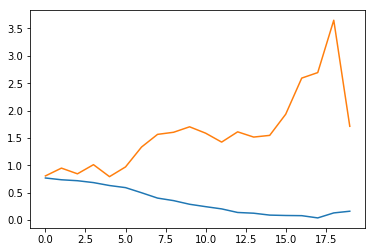

In [14]:
plt.plot(training_loss)
plt.plot(val_loss)

In [ ]:
nrois=10
nrois*(nrois-1)/2